In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import scipy.stats as sts
import ast
from scipy.interpolate import interp1d
from collections import OrderedDict
from matplotlib.transforms import blended_transform_factory
import matplotlib.lines as mlines

plt.close('all')
plt.style.use('default')
plt.rc('font', family='serif')
plt.rc('text', usetex=True)

LEGEND_FONT_SIZE = 12
AXIS_FONT_SIZE = 20
TICKS_FONT_SIZE = 17
TITLE_FONT_SIZE = 20
figs = []
%matplotlib inline
def running_mean(x, N):
    divider = np.convolve(np.ones_like(x), np.ones((N,)), mode='same')
    return np.convolve(x, np.ones((N,)), mode='same') / divider

In [2]:
linestyles = OrderedDict(
    [('solid',               (0, ())),
     ('loosely dotted',      (0, (1, 10))),
     ('dotted',              (0, (1, 5))),
     ('densely dotted',      (0, (1, 1))),

     ('loosely dashed',      (0, (5, 10))),
     ('dashed',              (0, (5, 5))),
     ('densely dashed',      (0, (5, 1))),

     ('loosely dashdotted',  (0, (3, 10, 1, 10))),
     ('dashdotted',          (0, (3, 5, 1, 5))),
     ('densely dashdotted',  (0, (3, 1, 1, 1))),

     ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1))),

     ('loosely dashdashdotted', (0, (3, 10, 3, 10, 1, 10))),
     ('dashdashdotted',         (0, (3, 5, 3, 5, 1, 5))),
     ('densely dashdashdotted', (0, (3, 1, 3, 1, 1, 1)))])

ls = [linestyles['solid'], linestyles['dashed'], linestyles['dotted'], 
      linestyles['dashdotted'], linestyles['dashdotdotted'], linestyles['dashdashdotted'],
      linestyles['densely dashed'], linestyles['densely dotted']]

col = ['c', 'k','orange', 'purple','r', 'b', 'g', 'y','brown','magenta','#BC8D0B']
markers = ['o', 's', 'v', 'D', 'x', '*', '|', '+', '^','2','1','3','4']


In [3]:
def plot_ci(xs, ys, conf, n, xlabel=None, ylabel=None, label=None, ax=None, **kwargs):
    
    if np.array(xs).ndim > 1:
        all_x = np.array(list(set(np.concatenate(xs).ravel().tolist())))
        all_x = np.sort(all_x)
        last_x = min(map(lambda x: max(x), xs))
        first_x = max(map(lambda x: min(x), xs))
        all_ys = []

        pred_x = np.linspace(first_x, last_x, 200)

        for i in range(len(xs)):
            f = interp1d(xs[i], ys[i], "linear")
            all_ys.append(f(pred_x))
        all_ys = np.array(all_ys)
    else:
        all_x = xs
        all_ys = ys
        pred_x = xs
    
    data_mean = np.mean(all_ys, axis=0)
    data_std = np.std(all_ys, axis=0) + 1e-24
    
    interval = sts.t.interval(conf, n-1,loc=data_mean,scale=data_std/np.sqrt(n))
    col = kwargs.get('color')
    if ax is None:
        fig, ax = plt.subplots(figsize=(4.8, 3.2))
        figs.append(fig)
    if label is None:
        ax.plot(pred_x, data_mean, **kwargs)
    else:
        ax.plot(pred_x, data_mean, label=label, **kwargs)
        
    if col is not None:
        ax.fill_between(pred_x, interval[0], interval[1], alpha=0.2, color=col, linewidth=0.)
    else:
        ax.fill_between(pred_x, interval[0], interval[1], alpha=0.2, linewidth=0.)
        
    if xlabel is not None:
        ax.set_xlabel(xlabel, fontsize=AXIS_FONT_SIZE)
    if ylabel is not None:
        ax.set_ylabel(ylabel, fontsize=AXIS_FONT_SIZE)
    ax.ticklabel_format(style='sci',scilimits=(0,0))
    ax.xaxis.offsetText.set_fontsize(TICKS_FONT_SIZE+2)
    ax.yaxis.offsetText.set_fontsize(TICKS_FONT_SIZE+2)
    ax.tick_params(labelsize=TICKS_FONT_SIZE)
    return ax

101 101
101 101
51 51
82 83


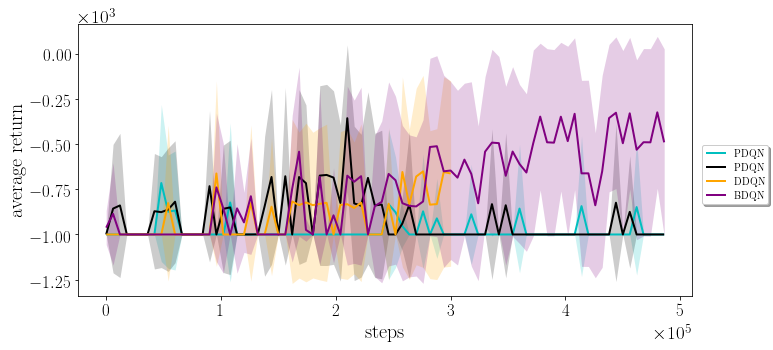

<Figure size 792x360 with 0 Axes>

In [5]:
environments = ['Mountain']#'BankHeist','Asterix','Asteroids'
algorithms = ['particle','dqn','boot']
eval_freq = 6e3
#policies = [['weighted'],['weighted-gaussian'],['boot','weighted'],['eps-greedy', 'boltzmann']]
updates = [['max_mean','weighted'],[''],[''],['weighted','max_mean'],['']]
alg_to_label={
        'particle':'PDQN',
        'gaussian':'GDQN',
        'dqn':'DDQN',
        'boot':'BDQN'
}
policy_to_label={
        'weighted':'W',
        'vpi':'V',
        'eps-greedy':'e-Gree',
        'boltzmann':'Boltz',
        'boot':'Boot',
        'weighted-gaussian':'W'
}
update_to_label={
        'weighted':'W',
        'max_mean':'M',
        '2_nets':'2-nets',
        'wider_1':'wider-1',
        'wider_2':'wider-2',
        'no_scaling':'no-scaling',
        '':''
}
alg_to_double_vec ={
        'particle-ql':['True'],
        'ql':['True'],
        'boot-ql':['True'],
        'gaussian-ql':['False'],
        'boot':['True']
}

conf = 0.95
n_rows = 82
subsample = 1
legend_labels = []
legend_colors = []
legend_markers = []
limits=[(-40,-10),(-10000,80000)]
for e,env in enumerate(environments):
    fig, ax = plt.subplots(1, 1, figsize=(11, 5))
    #fig.suptitle(env, fontsize=TITLE_FONT_SIZE)
    i = 0    
    for j, alg in enumerate(algorithms):
            for u in updates[j]:
                    if alg in ['particle']:
                        paths = glob.glob("./" + env + "/" + alg + "/"+ u + "/*.npy")
                    else:
                        paths = glob.glob("./" + env + "/" + alg + "/*.npy")                  
                    #print(paths)
                    res = []
                    min_rows = 350
                    max_rows = 0
                    for p in paths:
                        results = np.load(p)
                        if env == 'Mountain':
                            results[:,2][results[:,2]==0] = -1000
                        #print(results.shape)
                        n_runs = results.shape[0]
                        rows = min(n_runs,n_rows)
                        if n_runs < min_rows:
                            min_rows = n_runs
                        if n_runs > max_rows:
                            max_rows = n_runs
                        timesteps = np.array([i * eval_freq for i  in range(rows)])
                        cum_reward_test = results[:rows,2]
                        #cum_reward_test = np.expand_dims(cum_reward_test)
                        res.append(cum_reward_test)
                    if len(res) == 0:
                        continue
                    if e == 0:
                        legend_labels.append(alg_to_label[alg])
                        legend_colors.append(col[i])
                        legend_markers.append(markers[i])
                    print(min_rows,max_rows)
                    cum_reward_test = np.stack(res)
                    #print(cum_reward_test)
                    indexes = [i*subsample for i in range(len(timesteps) // subsample)]
                    
                        
                    ax = plot_ci(timesteps[indexes],cum_reward_test[:, indexes], conf, 
                                5, xlabel='steps', ylabel='average return', label=alg_to_label[alg] ,
                                 ax=ax, linewidth=2.0, linestyle=ls[0], color=col[i])
                    #ax.set_ylim(limits[e])
                        
                    i += 1
    lgd=fig.legend(loc='center right', 
                          ncol=1, fancybox=True, shadow=True)#,bbox_to_anchor=(0.42, 0)
    
    fig.savefig(env+".pdf",format='pdf', bbox_inches='tight',bbox_extra_artists=(lgd,))
    
fig = plt.figure(figsize=(11, 5))
patches = [ mlines.Line2D([], [], color=legend_colors[i], marker=legend_markers[i],
                          label=legend_labels[i])  for i in range(len(legend_labels)) ]

#lgd=fig.legend( patches, legend_labels, ncol=6, 
#           loc='center')
#fig.savefig('atari-legend.pdf',format='pdf',bbox_extra_artists=(lgd,), bbox_inches='tight')


